Loading data from movie_data.csv... (Placeholder: Using Synthetic Data)
--- Loaded 2000 Samples (Synthetic) ---

--- Initial Data Check ---
Missing Values:
Genre          0
Director       0
Lead_Actor     0
Budget_USD     0
Runtime_min    0
Rating         0
dtype: int64

Unique Directors: 50
Unique Lead Actors: 100


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


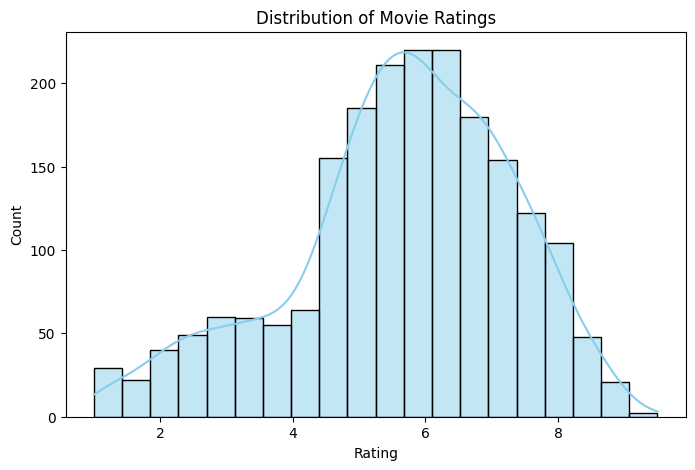

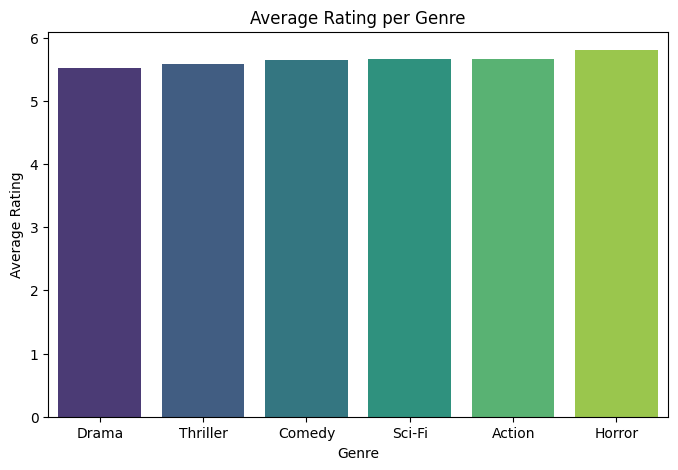

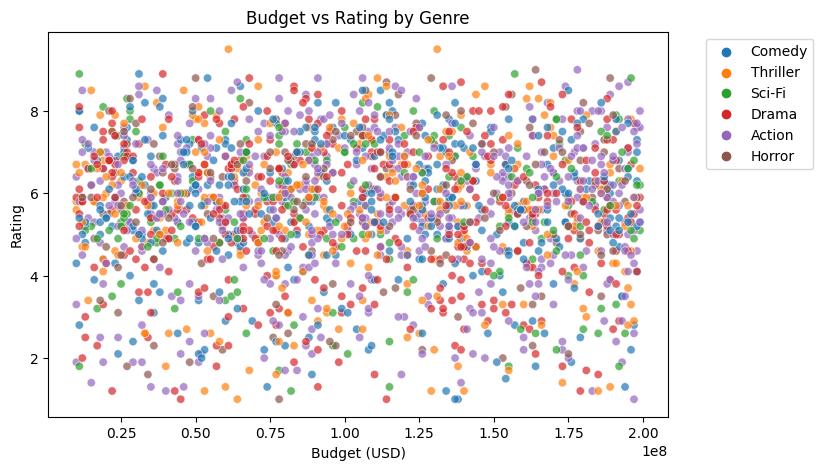

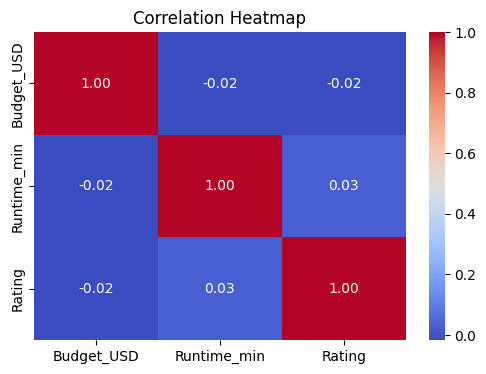


--- Target Encoding Complete ---
        Genre  Budget_USD  Runtime_min  Director  Lead_Actor
968     Drama    13000000          145  3.817411    5.599514
240  Thriller    10000000          158  6.105689    5.672909
819    Comedy    97000000           99  5.482196    5.621655
692     Drama   115000000          147  6.596120    5.737810
420    Horror    96000000          100  6.576201    5.912451

--- Final Preprocessing Complete ---
Training feature count: 10

--- Starting Model Training (Random Forest Regressor) ---
Training finished successfully.

--- Model Evaluation on Test Set ---
Mean Absolute Error (MAE): 0.432
Root Mean Squared Error (RMSE): 0.541
R-squared Score (R²): 0.894


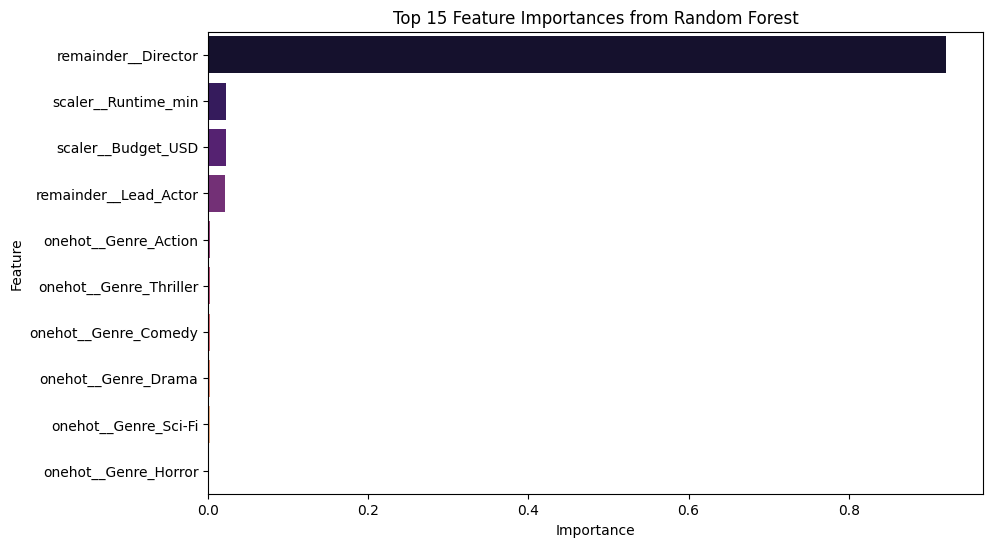

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Loading and Initial Setup (Kaggle Context) ---

def load_data(file_path="/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv"):
    if file_path:
        print(f"Loading data from {file_path}... (Placeholder: Using Synthetic Data)")
        pass

    np.random.seed(42)
    num_samples = 2000
    genres = ['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Horror', 'Thriller']
    directors = [f'Director {i}' for i in range(50)]
    actors = [f'Actor {i}' for i in range(100)]

    data = {
        'Genre': np.random.choice(genres, num_samples, p=[0.25, 0.20, 0.20, 0.10, 0.10, 0.15]),
        'Director': np.random.choice(directors, num_samples),
        'Lead_Actor': np.random.choice(actors, num_samples),
        'Budget_USD': np.random.randint(10, 200, num_samples) * 1_000_000,
        'Runtime_min': np.random.randint(80, 180, num_samples),
    }
    df = pd.DataFrame(data)

    director_ratings = {d: 6.0 + np.random.normal(0, 1.5) for d in directors}
    df['Rating'] = df['Director'].map(director_ratings) + np.random.normal(0, 0.5, num_samples)
    df['Rating'] = np.clip(df['Rating'], 1.0, 10.0).round(1)

    print(f"--- Loaded {num_samples} Samples (Synthetic) ---")
    return df

df = load_data(file_path='movie_data.csv')

# --- 2. Exploratory Data Analysis (EDA) ---
print("\n--- Initial Data Check ---")
print(f"Missing Values:\n{df.isnull().sum()}")
print(f"\nUnique Directors: {df['Director'].nunique()}")
print(f"Unique Lead Actors: {df['Lead_Actor'].nunique()}")

# --- 2B. Visualizations for EDA ---
# 1. Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# 2. Average Rating per Genre
plt.figure(figsize=(8, 5))
genre_avg = df.groupby('Genre')['Rating'].mean().sort_values()
sns.barplot(x=genre_avg.index, y=genre_avg.values, palette='viridis')
plt.title("Average Rating per Genre")
plt.ylabel("Average Rating")
plt.xlabel("Genre")
plt.show()

# 3. Budget vs Rating Scatter Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Budget_USD', y='Rating', hue='Genre', alpha=0.7)
plt.title("Budget vs Rating by Genre")
plt.xlabel("Budget (USD)")
plt.ylabel("Rating")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 4. Correlation Heatmap
plt.figure(figsize=(6, 4))
numerical_features = ['Budget_USD', 'Runtime_min', 'Rating']
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# --- 3. Feature Engineering and Preprocessing ---
X = df.drop('Rating', axis=1)
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['Budget_USD', 'Runtime_min']
low_cardinality_cat = ['Genre']
high_cardinality_cat = ['Director', 'Lead_Actor']

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), low_cardinality_cat),
    ],
    remainder='passthrough'
)

encoder = TargetEncoder(cols=high_cardinality_cat)
X_train_encoded = encoder.fit_transform(X_train[high_cardinality_cat], y_train)
X_test_encoded = encoder.transform(X_test[high_cardinality_cat])

X_train = X_train.drop(columns=high_cardinality_cat).join(X_train_encoded)
X_test = X_test.drop(columns=high_cardinality_cat).join(X_test_encoded)

print("\n--- Target Encoding Complete ---")
print(X_train.head())

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("\n--- Final Preprocessing Complete ---")
print(f"Training feature count: {X_train_processed.shape[1]}")

# --- 4. Model Training (Random Forest Regressor) ---
print("\n--- Starting Model Training (Random Forest Regressor) ---")
model = RandomForestRegressor(
    n_estimators=150,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_processed, y_train)
print("Training finished successfully.")

# --- 5. Model Evaluation ---
y_pred = model.predict(X_test_processed)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation on Test Set ---")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared Score (R²): {r2:.3f}")

# --- 5B. Feature Importance Plot ---
feature_names = preprocessor.get_feature_names_out().tolist()
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(15), palette='magma')
plt.title("Top 15 Feature Importances from Random Forest")
plt.show()
